In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.95

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "exoverstation," + \
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   catanzaro
   2   la_spezia
   3   bologna
   4   siena
   5   sondrio
   6   pordenone
   7   palermo
   8   salerno
   9   bolzano
   10   treviso
   11   parma
   12   livorno
   13   messina
   14   macerata
   15   lucca
   16   pistoia
   17   catania
   18   terni
   19   l_aquila
   20   bat
   21   trento
   22   pescara
   23   agrigento
   24   belluno
   25   rieti
   26   foggia
   27   pisa
   28   reggio_di_calabria
   29   ascoli_piceno
   30   cremona
   31   ancona
   32   ferrara
   33   fermo
   34   bergamo
   35   taranto
   36   mantova
   37   biella
   38   roma
   39   cosenza
   40   matera
   41   torino
   42   enna
   43   modena
   44   arezzo
   45   savona
   46   varese
   47   forli
   48   udine
   49   benevento
   50   isernia
   51   vicenza
   52   chieti
   53   teramo
   54   napoli
   55   monza
   56   pavia
   57   lecce
   58   como
   59   alessandria
   60   c

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    #if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    #if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
            ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 catanzaro
2 la_spezia
3 bologna
4 siena
5 sondrio
6 pordenone
7 palermo
8 salerno
9 treviso
10 parma
11 livorno
12 macerata
13 lucca
14 pistoia
15 catania
16 terni
17 l_aquila
18 bat
19 trento
20 pescara
21 agrigento
22 belluno
23 rieti
24 foggia
25 pisa
26 reggio_di_calabria
27 ascoli_piceno
28 cremona
29 ancona
30 ferrara
31 bergamo
32 taranto
33 mantova
34 biella
35 roma
36 cosenza
37 matera
38 torino
39 enna
40 modena
41 arezzo
42 savona
43 varese
44 forli
45 udine
46 benevento
47 vicenza
48 chieti
49 teramo
50 napoli
51 monza
52 pavia
53 lecce
54 como
55 alessandria
56 cagliari
57 cuneo
58 reggio_nell_emilia
59 latina
60 oristano
61 genova
62 bari
63 lecco
64 venezia
65 brescia
66 padova
67 frosinone
68 grosseto
69 nuoro
70 asti
71 ravenna
72 gorizia
73 perugia
74 vibo_valentia
75 piacenza
76 vercelli
77 sassari
78 trieste
79 firenze
80 novara
81 milano
82 massa
83 prato
84 avellino
85 lodi
86 crotone
87 verona
88 pesaro
89 rovigo
90 potenza
91 brindisi
92 viterbo
93 rimini
94 c

In [4]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Using:         

Training set average RMSE:  0.36068  0.02624 
    Test set average RMSE:  0.98797  0.10926 
             Fullset RMSE:  0.35950
                       R2:  0.93848


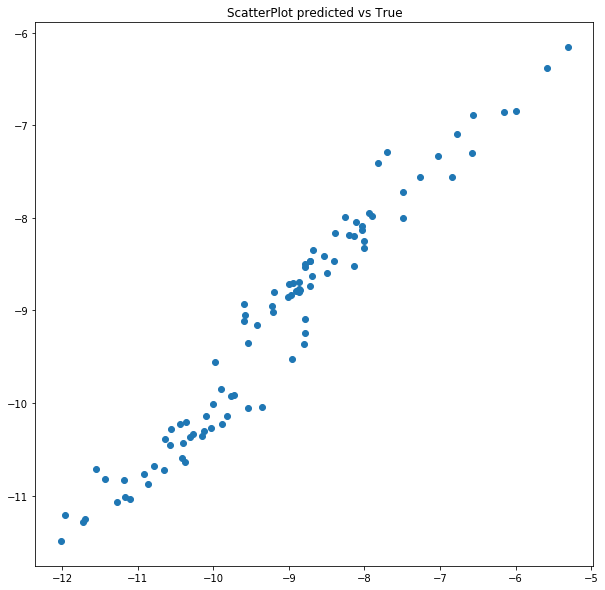

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02813
Feature:               commutersdensity, Score: 0.03828
Feature:                         depriv, Score: 0.02750
Feature:                            lat, Score: 0.59661
Feature:                 Ratio0200ver65, Score: 0.05548
Feature:           avg_wco_period1_2020, Score: 0.02484
Feature:          avg_wnh3_period1_2020, Score: 0.07623
Feature:           avg_wno_period1_2020, Score: 0.05426
Feature:           avg_wo3_period1_2020, Score: 0.04515
Feature:         avg_wpans_period1_2020, Score: 0.02510
Feature:          avg_wso2_period1_2020, Score: 0.02841


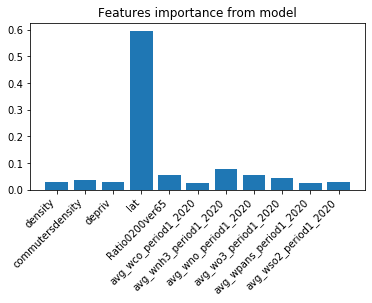

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.04887
Feature:               commutersdensity, Score: 0.02585
Feature:                         depriv, Score: 0.04892
Feature:                            lat, Score: 2.68596
Feature:                 Ratio0200ver65, Score: 0.13438
Feature:           avg_wco_period1_2020, Score: 0.06089
Feature:          avg_wnh3_period1_2020, Score: 0.14870
Feature:           avg_wno_period1_2020, Score: 0.14388
Feature:           avg_wo3_period1_2020, Score: 0.09530
Feature:         avg_wpans_period1_2020, Score: 0.04538
Feature:          avg_wso2_period1_2020, Score: 0.05956


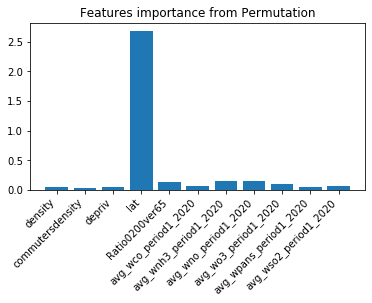

<Figure size 720x720 with 0 Axes>

((0.3606848356632665, 0.026243808126141275),
 (0.987973169490286, 0.10926040887779859),
 0.35949839260252214,
 {'density': 0.013971089904807015,
  'commutersdensity': 0.007391537252632548,
  'depriv': 0.013985334765566442,
  'lat': 0.7679249761214204,
  'Ratio0200ver65': 0.03842049576074526,
  'avg_wco_period1_2020': 0.017407499325205567,
  'avg_wnh3_period1_2020': 0.04251316935646509,
  'avg_wno_period1_2020': 0.0411352093261279,
  'avg_wo3_period1_2020': 0.027246533563443618,
  'avg_wpans_period1_2020': 0.012975287781746324,
  'avg_wso2_period1_2020': 0.01702886684183975})

In [5]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True)

Training set average RMSE:  0.38636  0.02914 
    Test set average RMSE:  1.04625  0.11271 
             Fullset RMSE:  0.36793
                       R2:  0.93556


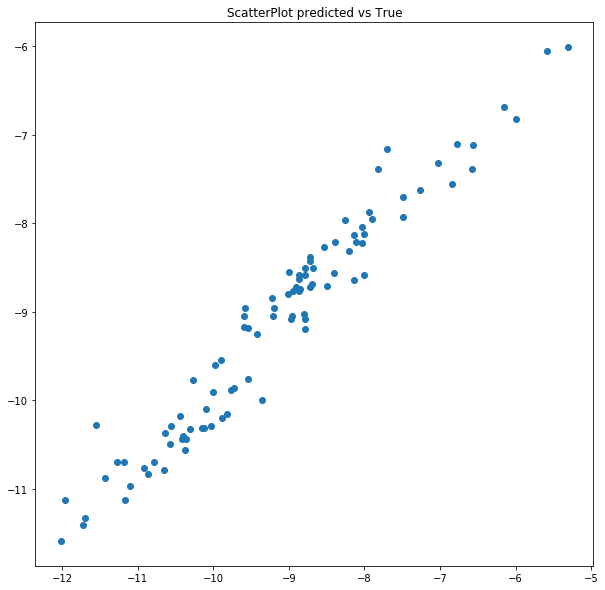

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03405
Feature:               commutersdensity, Score: 0.39471
Feature:                         depriv, Score: 0.03964
Feature:                 Ratio0200ver65, Score: 0.09802
Feature:           avg_wco_period1_2020, Score: 0.06551
Feature:          avg_wnh3_period1_2020, Score: 0.10155
Feature:           avg_wno_period1_2020, Score: 0.14540
Feature:           avg_wo3_period1_2020, Score: 0.04827
Feature:         avg_wpans_period1_2020, Score: 0.03212
Feature:          avg_wso2_period1_2020, Score: 0.04073


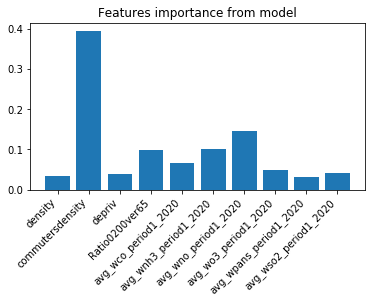

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.05579
Feature:               commutersdensity, Score: 1.35905
Feature:                         depriv, Score: 0.04830
Feature:                 Ratio0200ver65, Score: 0.14231
Feature:           avg_wco_period1_2020, Score: 0.11799
Feature:          avg_wnh3_period1_2020, Score: 0.19877
Feature:           avg_wno_period1_2020, Score: 0.29080
Feature:           avg_wo3_period1_2020, Score: 0.08333
Feature:         avg_wpans_period1_2020, Score: 0.07398
Feature:          avg_wso2_period1_2020, Score: 0.08986


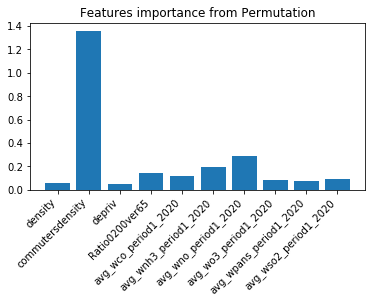

<Figure size 720x720 with 0 Axes>

((0.38636331269184504, 0.02913741999320799),
 (1.0462488161564167, 0.11270503992173342),
 0.3679310487475222,
 {'density': 0.022676390373330087,
  'commutersdensity': 0.5524194728868665,
  'depriv': 0.01963478523602894,
  'Ratio0200ver65': 0.057843975055188325,
  'avg_wco_period1_2020': 0.047959370225482904,
  'avg_wnh3_period1_2020': 0.08079394700334552,
  'avg_wno_period1_2020': 0.11820302796931888,
  'avg_wo3_period1_2020': 0.0338716266383598,
  'avg_wpans_period1_2020': 0.03007154838711476,
  'avg_wso2_period1_2020': 0.03652585622496418})

In [6]:
featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True)

Training set average RMSE:  0.40915  0.03018 
    Test set average RMSE:  1.05223  0.11788 
             Fullset RMSE:  0.39327
                       R2:  0.92638


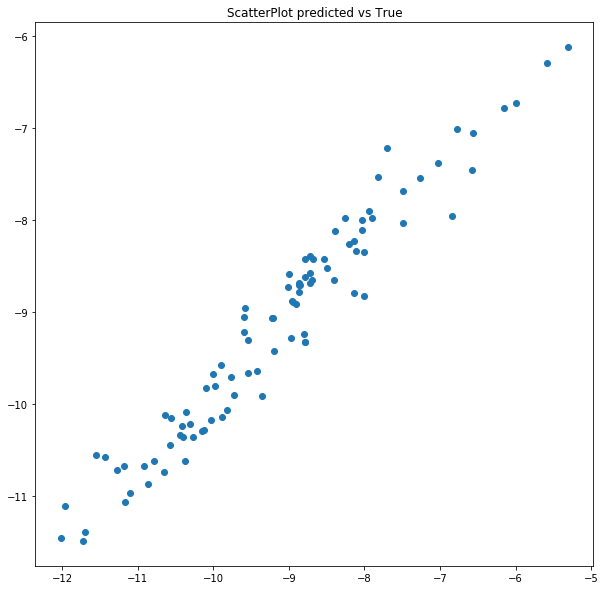

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.04386
Feature:                         depriv, Score: 0.21586
Feature:                 Ratio0200ver65, Score: 0.06504
Feature:           avg_wco_period1_2020, Score: 0.10731
Feature:          avg_wnh3_period1_2020, Score: 0.10805
Feature:           avg_wno_period1_2020, Score: 0.32356
Feature:           avg_wo3_period1_2020, Score: 0.04945
Feature:         avg_wpans_period1_2020, Score: 0.03458
Feature:          avg_wso2_period1_2020, Score: 0.05229


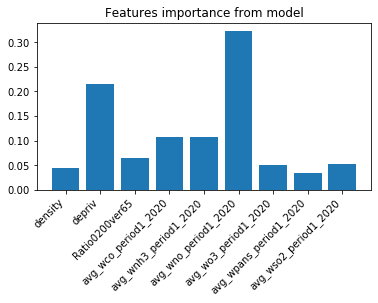

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.07449
Feature:                         depriv, Score: 0.63987
Feature:                 Ratio0200ver65, Score: 0.13996
Feature:           avg_wco_period1_2020, Score: 0.22644
Feature:          avg_wnh3_period1_2020, Score: 0.28576
Feature:           avg_wno_period1_2020, Score: 0.69285
Feature:           avg_wo3_period1_2020, Score: 0.07744
Feature:         avg_wpans_period1_2020, Score: 0.09996
Feature:          avg_wso2_period1_2020, Score: 0.08153


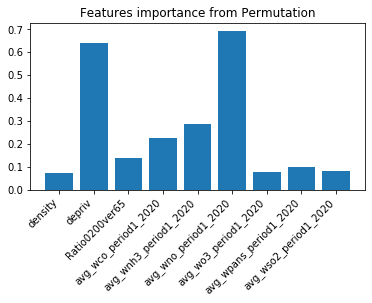

<Figure size 720x720 with 0 Axes>

((0.40914932659296194, 0.030179680041494773),
 (1.0522334133705658, 0.117883531757127),
 0.39327263920597383,
 {'density': 0.03213078020185721,
  'depriv': 0.27600571421629944,
  'Ratio0200ver65': 0.06037329023581843,
  'avg_wco_period1_2020': 0.09767549547358541,
  'avg_wnh3_period1_2020': 0.12326256025338621,
  'avg_wno_period1_2020': 0.29886212023521763,
  'avg_wo3_period1_2020': 0.03340445393493607,
  'avg_wpans_period1_2020': 0.04311729723942008,
  'avg_wso2_period1_2020': 0.03516828820947953})

In [7]:
featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True)

In [8]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf = smlmodule.rfregressors_optimizer (X, Y)

print(bestf.best_params_)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
